In [ ]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


import pywt
from scipy import signal
import itertools
import operator

from scipy.fft import fft, ifft
from scipy import fftpack
import math

from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
# Set the seed
np.random.seed(42)

# Set the directory 
gtzan_dir = 'Data/'

# Map genres into integers
#song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [ ]:
def get_features(y, sr, n_fft = 1024, hop_length = 512, window_samples=65536, n_windows=43, 
                 low_bpm=40, high_bpm=200, alpha=0.99, downsampling_factor=16, sampling_rate=22050, 
                replication_factors_dwt=[2], replication_factors_fft=[2]):
    # Features to concatenate in the final dictionary

    features = {'centroid': None, 'roloff': None, 'flux': None, #'rmse': None,
                    'zcr': None, 
                #'contrast': None, 
                #'bandwidth': None, 
                #'flatness': None
               }



    #spectral centroid
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()

    #folloff
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()

    #zerocrossing
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()

    #flux
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()



    #5 MFCC coefficients over the texture window
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=5)
    for idx, v_mfcc in enumerate(mfcc):
        #remove DC coefficient
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()[1:]

    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_var'.format(k)] = np.std(v)**2
        return result

    dict_agg_features = get_moments(features)

    #low energy
    rmse_analysis=librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    rmse_texture=librosa.feature.rms(y, frame_length=n_fft, hop_length=n_windows*hop_length).ravel()
    perc=0
    for i in range(len(rmse_analysis)): 
        if rmse_analysis[i]>rmse_texture[np.int(i/n_windows)]:
            perc+=1

    dict_agg_features['low_energy']=perc/len(rmse_analysis)


    #window_samples=65536
    bh={}
    fph={}
    uph={}

    for i in range(low_bpm, high_bpm):
        bh[i]=0

    for i in range(np.int(len(y)/window_samples)):
        y_wind=y[i*window_samples:(i+1)*window_samples]


        cA, cD = pywt.dwt(y_wind, 'db1')
        
        cA=pywt.idwt(cA, None, 'db1')
        cD=pywt.idwt(None, cD, 'db1')

        #alpha=0.99
        low_passed_cA=(1-alpha)*np.abs(cA[1:])-alpha*(cA[:-1])
        downsampled_cA=low_passed_cA[::downsampling_factor]-np.mean(low_passed_cA)

        low_passed_cD=(1-alpha)*np.abs(cD[1:]-alpha*(cD[:-1]))
        downsampled_cD=low_passed_cD[::downsampling_factor]-np.mean(low_passed_cD)

        #####
        downsampled=downsampled_cA+downsampled_cD
#        downsampled=pywt.idwt(downsampled_cA, None, 'db1')+pywt.idwt(None,downsampled_cD, 'db1')

        corr= ((signal.correlate(downsampled, downsampled)/len(downsampled)).clip(min=0))[int(len(downsampled)):]
#        corr_scaled=(corr-np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in corr)))[: len(corr)]).clip(min=0)

        corr_scaled=corr
        ind={}
        for replication_factor in replication_factors_dwt:
            ind[str(replication_factor)]=[]
            
        for x in range(len(corr_scaled)):
            for replication_factor in replication_factors_dwt:
                if x%replication_factor!=0:
                    ind[str(replication_factor)].append(x)
        
        for replication_factor in replication_factors_dwt: 
            corr_scaled=corr_scaled-np.array(list(np.insert(corr, list(ind[str(replication_factor)]), 0, axis=0)))[:len(corr_scaled)].clip(min=0)
        
        #corr_scaled=(corr-np.array(list(np.insert(corr, [x+1 for x in range(len(corr))], 0, axis=0)))[:len(corr)]).clip(min=0)

        stop=1/(low_bpm/60)
        start=1/(high_bpm/60)
        delta_t=(downsampling_factor*1/sampling_rate)


        corr_cut=corr_scaled[np.int(np.floor(start/delta_t)): np.int(np.ceil(stop/delta_t))]
        offset=len(corr_scaled[:np.int(np.floor(start/delta_t))])*delta_t


        all_peak_freq= signal.find_peaks(corr_cut, distance=100) 
        # ditance cerca i picchi distanti almeno 10 bpm che magari un po di 
        #rumore nel campionamento ti fa avere picchi molto vicini che però dan poca info
        dict_peaks={}
        for i in all_peak_freq[0]:
            dict_peaks[i]=corr_cut[i]

        max_peaks=dict(sorted(dict_peaks.items(), key = operator.itemgetter(1), reverse = True)[:3])
        peak_bpm=[np.int(x) for x in 60*(1/(np.array([np.int(x) for x in max_peaks.keys()])*delta_t + offset))]

        for freq, peak in max_peaks.items():
            bh[np.int(60*1/(np.int(freq)*delta_t + offset))]+=peak

        
        f_s=sampling_rate
        yf = fft(y_wind)
        N=len(y_wind)
        freqs = np.arange(-N/2, N/2, 1)*(f_s/(N/2))

        
        yf_a=np.real(ifft(np.concatenate([np.zeros(len(yf[(freqs<1000)&(freqs>=0)])), yf[freqs>=1000], np.zeros(len(yf[(freqs>-1000)&(freqs<0)])), yf[freqs<=-1000]])).clip(min=0))
        yf_b=np.real(ifft(np.concatenate([yf[(freqs>=0)&(freqs<1000)], np.zeros(len(yf[freqs>=1000])), yf[(freqs>-1000)&(freqs<0)], np.zeros(len(yf[freqs<=-1000]))])).clip(min=0))

        low_passed_cA=(1-alpha)*(yf_a[1:])-alpha*(yf_a[:-1])
        downsampled_cA=low_passed_cA[::downsampling_factor]-np.mean(low_passed_cA)

        low_passed_cD=(1-alpha)*(yf_b[1:])-alpha*(yf_b[:-1])
        downsampled_cD=low_passed_cD[::downsampling_factor]-np.mean(low_passed_cD)

        downsampled=downsampled_cA+downsampled_cD

        corr= ((signal.correlate(downsampled, downsampled)/len(downsampled)).clip(min=0))[int(len(downsampled)):].clip(min=0)
        #corr_scaled=(corr-np.array(list(np.insert(corr, [x+1 for x in range(len(corr))], 0, axis=0)))[:len(corr)]).clip(min=0)
        
        corr_scaled=corr
        ind={}
        for replication_factor in replication_factors_fft:
            ind[str(replication_factor)]=[]
            
        for x in range(len(corr_scaled)):
            for replication_factor in replication_factors_fft:
                if x%replication_factor!=0:
                    ind[str(replication_factor)].append(x)
        
        for replication_factor in replication_factors_fft: 
            corr_scaled=corr_scaled-np.array(list(np.insert(corr, list(ind[str(replication_factor)]), 0, axis=0)))[:len(corr_scaled)].clip(min=0)
        
        
        stop=1/(low_bpm/60)
        start=1/(high_bpm/60)
        delta_t=(downsampling_factor*1/sampling_rate)

        corr_cut=corr_scaled[np.int(np.floor(start/delta_t)): np.int(np.ceil(stop/delta_t))]
        offset=len(corr_scaled[:np.int(np.floor(start/delta_t))])*delta_t

        all_peak_freq= signal.find_peaks(corr_cut, distance=100)

        dict_peaks={}
        for i in all_peak_freq[0]:
            dict_peaks[i]=corr_cut[i]

        max_peaks=dict(sorted(dict_peaks.items(), key = operator.itemgetter(1), reverse = True)[:3])

        for freq, peak in max_peaks.items():
            n=np.int(12*math.log2(freq/440) + 69)
            if n in uph.keys():
                uph[n]+=peak
            else: 
                uph[freq]=peak

            c=7*(n%12)%12
            if c in fph.keys():
                fph[c]+=peak
            else: 
                fph[c]=peak
        
    bh_max_peaks=dict(sorted(bh.items(), key = operator.itemgetter(1), reverse = True)[:2])
    sum_of_amplitudes=sum((bh.values()))
    dict_agg_features['a0']=list(bh_max_peaks.values())[0]/sum_of_amplitudes
    dict_agg_features['a1']=list(bh_max_peaks.values())[1]/sum_of_amplitudes
    dict_agg_features['ra']=list(bh_max_peaks.values())[1]/list(bh_max_peaks.values())[0]
    dict_agg_features['p1']=list(bh_max_peaks.keys())[0]
    dict_agg_features['p2']=list(bh_max_peaks.keys())[1]
    dict_agg_features['sum_amplitudes']=sum_of_amplitudes 
    
    fph_max_peaks=dict(sorted(fph.items(), key = operator.itemgetter(1), reverse = True)[:2])
    uph_max_peaks=dict(sorted(fph.items(), key = operator.itemgetter(1), reverse = True)[:1])

   
    dict_agg_features['sum_ph']=sum((uph.values()))
    dict_agg_features['fa0']=list(fph_max_peaks.values())[0]
    dict_agg_features['up0']=list(uph_max_peaks.keys())[0]
    dict_agg_features['fp0']=list(fph_max_peaks.keys())[0]
    dict_agg_features['ipo1']=np.abs(list(fph_max_peaks.keys())[0] - list(fph_max_peaks.keys())[0])

    return dict_agg_features

In [ ]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        print(x)
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr, n_fft = 1024, hop_length = 512, window_samples=65536, n_windows=43, 
                 low_bpm=40, high_bpm=200, alpha=0.99, downsampling_factor=16, sampling_rate=22050, 
                replication_factors_dwt=[2,3,4,5,8], replication_factors_fft=[2,3,4,5,8])
                
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [ ]:
# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=False)

metal


/home/disma_user/sbuccafusco/.local/lib/python3.7/site-packages/librosa/filters.py:230: RuntimeWarning: divide by zero encountered in true_divide
  enorm = 2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])


disco
classical
hiphop
jazz
country
pop
blues
reggae
rock


In [ ]:
df=pd.DataFrame.from_dict(features)
#30 dimensional features vector
df

,centroid_mean,centroid_var,roloff_mean,roloff_var,flux_mean,flux_var,zcr_mean,zcr_var,mfcc_0_mean,mfcc_0_var,...,ra,p1,p2,sum_amplitudes,sum_ph,fa0,up0,fp0,ipo1,genre
0,2643.487076,407543.200217,5412.078333,9.127002e+05,1.232635,1.492952,0.135000,0.004028,-274.383911,1614.339235,...,0.956877,41,85,0.003941,0.000937,0.000193,0,0,0,0
1,2147.049597,155574.193074,4376.752601,7.091884e+05,1.156895,0.642008,0.128326,0.001183,-133.911728,1024.497375,...,0.865379,114,74,0.028230,0.007174,0.001604,4,4,0,0
2,2574.352882,195679.169772,5214.382545,5.871349e+05,1.310780,1.133507,0.157726,0.001879,-120.041603,1607.677951,...,0.379768,51,102,0.043990,0.009951,0.002778,2,2,0,0
3,2202.509406,122935.997031,5052.259009,3.328054e+05,1.085739,0.425552,0.094636,0.000830,-68.575134,569.890494,...,0.769996,170,113,0.731256,0.035422,0.057642,7,7,0,0
4,3021.513262,129589.271691,5684.482513,3.501305e+05,1.149498,0.548425,0.203504,0.001822,-158.292618,1050.311163,...,0.684519,165,67,0.012807,0.003344,0.000683,10,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2191.673111,393094.646764,4660.814353,1.814201e+06,1.002939,0.830336,0.115548,0.002610,-157.057922,2989.610001,...,0.833654,115,188,0.063169,0.010589,0.002107,7,7,0,9
996,1314.911489,245570.641955,2800.049168,1.455538e+06,1.151901,1.088890,0.048712,0.000934,-294.786560,10742.484599,...,0.941107,74,110,0.033680,0.005271,0.001364,4,4,0,9
997,2095.320392,258261.531562,4126.980768,9.272549e+05,1.192738,0.693919,0.121545,0.003343,-126.927971,1286.460612,...,0.779596,166,94,0.044056,0.009358,0.003368,4,4,0,9
998,2838.965334,899606.430212,6370.697234,2.466647e+06,1.400210,2.795072,0.120885,0.006963,-139.141907,2496.148259,...,0.481329,172,171,0.091543,0.014902,0.004387,2,2,0,9


In [ ]:
x=df.iloc[:, :-1]
y=df.iloc[:, -1]

scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)

scores = []
best_svc = SVC(kernel='poly')

predicted_targets = np.array([])
actual_targets = np.array([])

for n_iter in range(0,100):
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    for train_index, test_index in cv.split(x, y):
        X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]

        best_svc.fit(X_train, y_train)
        
        predicted_labels = best_svc.predict(X_test)
        
        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, y_test)
    
        scores.append(best_svc.score(X_test, y_test))

/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:385: RuntimeWarning: divide by zero encountered in true_divide
  _handle_zeros_in_scale(data_range))


In [ ]:
print('AVG acccuracy ' + str(np.mean(scores)))

AVG acccuracy 0.671


In [ ]:
def plot_confusion_matrix(predicted_labels_list, y_test_list, class_names):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.savefig('Results/confusion_matrix1.png')
    plt.rcParams["figure.figsize"] = (10,10)
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    plt.rcParams["figure.figsize"] = (10,10)
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.savefig('Results/confusion_matrix2.png')
    plt.show()
    
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

Confusion matrix, without normalization


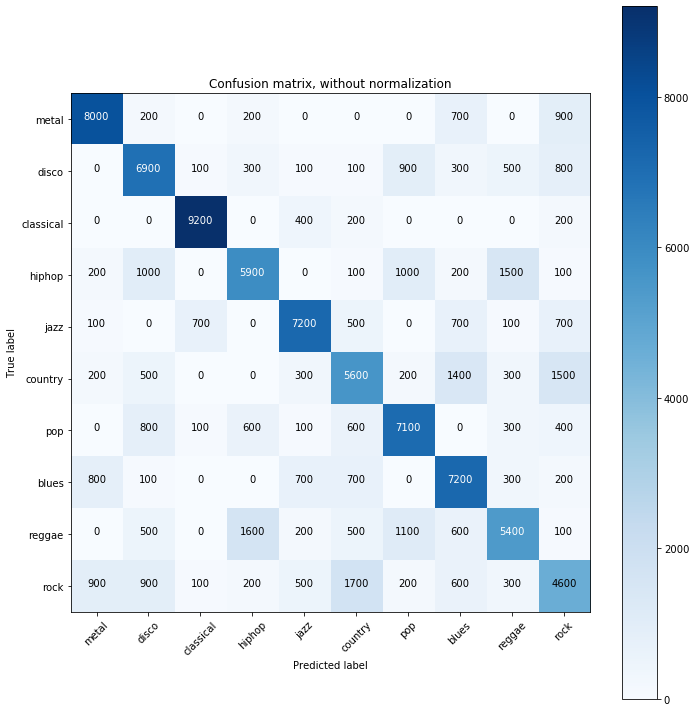

Normalized confusion matrix


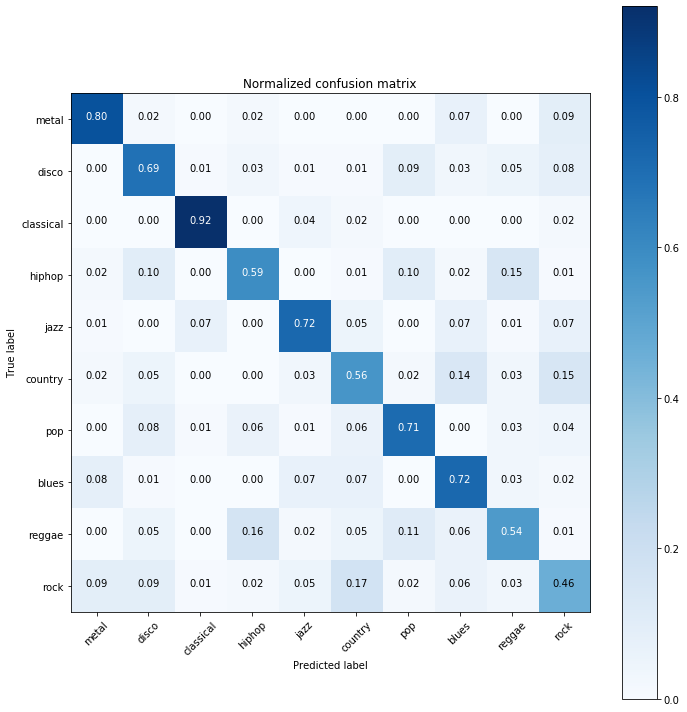

In [ ]:
plot_confusion_matrix(predicted_targets, actual_targets, list(genres.keys()))